### Import Librerie e caricamento del Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm 
import pylab as py 
import datetime
import matplotlib as mpl
import seaborn as sns
from pandas.api.types import CategoricalDtype
from statsmodels.graphics.tsaplots import plot_pacf
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from time import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

datasetDL = pd.read_csv("serie-storiche-ecommerce.csv", sep =",")
pd.set_option('display.max_rows', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Fase di Pre-Processing

In [3]:
datasetDL.index.name = "data"
#print(datasetDL.index.name)
datasetDL["totale"] = datasetDL["data"] + "." + datasetDL["totale"] #unione delle colonne in quanto l'import del dataset riscontra dei problemi 
datasetDL["totale"]= datasetDL["totale"].str.replace("'","")
datasetDL=datasetDL.drop(columns="data")
#display(datasetDL)

In [4]:
x = datasetDL["settore"].unique() #inserimento nell'array dei possibili settori
x=x.tolist() #trasformazione da array a lista
index=15 #in posizione 15 c'è il valore Nan che deve essere eliminato
x.pop(index) #viene eliminato il valore Nan 
#print(x)

#ciclo per sistemare i valori che contengono Nan andando ad inserire il Settore e il Totale corretto 
for index, row in datasetDL.iterrows():
    if (row['settore'] not in x):
            row['settore'] = row['totale'].split('.')[1]
            row['totale'] = row['totale'].split('.')[0]
datasetDL["totale"]=datasetDL["totale"].astype(float)
datasetDL = datasetDL.reset_index()
#display(datasetDL) 

### Statistica Descrittiva

In [5]:
dataCasual = datasetDL[datasetDL['settore'] == "Casual"]

#cambiato il valore della riga con index 2316 (2020-07-31, -2159.18) perchè negativo
#sostituito in modo da non avere problemi nell'analisi della stagionalità
datasetDL.loc[20097,['totale']] = 0.1
#datasetDL

In [6]:
datasetDL.groupby('settore').describe()

totale                                                   \
                  count          mean           std      min         25%   
settore                                                                    
Arceria             7.0    519.330000    479.763142    71.23    143.6800   
Arti marziali     139.0    760.717194    711.336248   122.81    243.1500   
Bambino          1250.0   2083.043672   2172.618008    81.87    762.2100   
Baseball           60.0    463.274500    264.859403   161.01    365.9600   
Basket            922.0   1793.860390   1409.098156   120.08    787.3150   
Buoni / acconti     7.0   2729.000000   1929.694406  1364.50   1364.5000   
Calcio           2956.0  13215.077493  13910.280138   106.43   5171.7975   
Casual           2901.0  12226.927956   9168.822341     0.10   5642.2100   
Ciclismo          759.0    978.939789   1416.752589    54.58    270.7200   
Danza              53.0    512.007547    556.998460   109.16    316.8400   
Fitness          2834.0   8887.481136  27940.749429    45.44   2341.6200   
Freccette          10.0   1633.632000    924.861542   734.10   1225.5900   
Golf               31.0   2401.829677   2099.746604   212.86    733.1450   
Intimo              4.0   1487.305000    620.909974   955.15    955.1500   
Mare             1009.0   1799.722131   1705.351755   135.09    685.8000   
Nuoto             949.0    777.835985    608.102485    57.04    368.4200   
Padel             191.0   5190.539948   4013.113861   136.45   2999.1700   
Pattini           154.0   1286.765130   1058.878659   242.88    408.7350   
Pesca            2978.0  18494.435480  11543.885015    36.84  10070.4900   
Ping-pong         105.0    718.353429    810.160836    54.31    188.3000   
Rugby              73.0   1201.385753    710.748701   169.47    757.3000   
Running          2271.0   5040.842554   4261.376770     0.00   2213.9000   
Sci              1209.0   7842.052672   8391.974503     2.73   1760.2100   
Skateboard         94.0   1275.693085    993.344962    98.24    611.5700   
Snowboard        1372.0   4368.104964   5006.850072    95.52   1134.1700   
Soft air            1.0    136.450000           NaN   136.45    136.4500   
Subacquea         162.0   1204.627901   1833.318167   147.37    488.7600   
Tennis            972.0   2039.352294   2054.405058    36.84    614.0300   
Trekking         1514.0   3764.138137   3661.227758   121.44   1335.3000   
Volley            274.0   1142.115292    887.329796   215.59    486.3100   

                                                   
                       50%         75%        max  
settore                                            
Arceria            569.820    628.9000    1449.10  
Arti marziali      670.520   1104.0150    6432.53  
Bambino           1361.770   2676.4675   25858.09  
Baseball           379.330    399.7975    1844.80  
Basket            1471.200   2307.7075   12255.94  
Buoni / acconti   2729.000   2729.0000    6822.50  
Calcio            9407.970  15947.5250  171365.37  
Casual           10252.030  16419.3000   98255.46  
Ciclismo           517.960   1078.7700   13372.10  
Danza              352.040    486.3100    3520.41  
Fitness           4328.330   7727.8275  516104.93  
Freccette         1225.590   2144.7900    3676.78  
Golf              2033.110   3905.2000    9349.55  
Intimo            1432.725   1964.8800    2128.62  
Mare              1220.410   2330.8400   13740.79  
Nuoto              633.670    979.9800    5185.10  
Padel             4584.720   6860.7050   33070.02  
Pattini           1225.590   1654.7925    5887.27  
Pesca            16851.300  25013.0575   84700.25  
Ping-pong          485.220    971.5200    5703.61  
Rugby             1226.690   1500.9500    3745.55  
Running           3891.550   6787.4300   55733.00  
Sci               5387.050  10902.3600   58780.48  
Skateboard         917.490   1606.9025    5654.49  
Snowboard         2469.065   5681.0950   50980.72  
Soft air           136.450    136.4500     136.45  


In [7]:
dataCasual = datasetDL[datasetDL['settore'] == "Casual"]

Casual


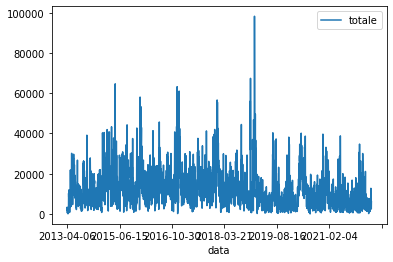

In [8]:
print("Casual")
dataCasual.plot('data', 'totale')

## Raggruppati i dati di ogni settore per mese e fatta la somma del totale di ogni mese di tutti gli anni (gennaio 2013,+gennaio 2014+ ... + gennaio 2022 ecc.) --> dataCasualTotalePerMese

## Raggruppati i dati di ogni settore per mese e separati in base all'anno (gennaio 2013, febbraio 2013, ..., gennaio 2015, febbraio 2015, ..., aprile 2022) --> dataCasualAnnoMese

In [9]:
def function(dataSp, dataSpAnnoMese, dataSpTotalePerMese, dataSpMese):
    dataSp = dataSp.set_index('data')
    dataSp.index = pd.to_datetime(dataSp.index)
    dataSpAnnoMese = dataSp.groupby([(dataSp.index.year), (dataSp.index.month)]).sum()
    # print(dataSpAnnoMese)
    dataSpTotalePerMese = dataSp.groupby([(dataSp.index.month)]).sum()
    # print(dataSpTotalePerMese)
    
    dataSpMese = dataSp.groupby(pd.Grouper(freq="M")).sum()
    
    dataSpMese['year'] = [d.year for d in dataSpMese.index]
    dataSpMese['month'] = [d.strftime('%b') for d in dataSpMese.index]
    years = dataSpMese['year'].unique()

    # print(dataSpMese)
    
    np.random.seed(100)
    mycolors = ["blue",  "green" ,"black" , "cyan", "magenta", "lime", "red", "indigo", "royalblue", "brown"]
    plt.figure(figsize=(10, 8), dpi = 80)
    for i, y in enumerate(years):
        if i > 0:        
            plt.plot('month', 'totale', data=dataSpMese.loc[dataSpMese.year==y, :], color=mycolors[i], label=y)
            plt.text(dataSpMese.loc[dataSpMese.year==y, :].shape[0]-.9, dataSpMese.loc[dataSpMese.year==y, 'totale'][-1:].values[0],
                     y, fontsize=12, color=mycolors[i])

    plt.gca().set(xlim=(-0.3, 11), ylabel='$Totale (Milioni-€)$', xlabel='$Mese$')
    plt.yticks(fontsize=12, alpha=.7)
    plt.title("Serie Storiche E-commerce Casual Divisa Per Anno", fontsize=20)
    plt.show()

    return dataSpAnnoMese, dataSpTotalePerMese, dataSpMese

In [10]:
def totaleAnno(dataSpAnno, dataSp, strSp):
    dataSp = dataSp.set_index('data')
    dataSp.index = pd.to_datetime(dataSp.index)
    
    dataSpAnno = dataSp.groupby(pd.Grouper(freq="Y")).sum()
    dataSpAnno['year'] = [d.year for d in dataSpAnno.index]
    dataSpAnno['NumAnno'] = dataSpAnno.year.apply(lambda x: 0 if x==2013 else(1 if x==2014 else 2 if x==2015 else 3 if x==2016 else 4 if x==2017 else 5 if x==2018 else 6 if x==2019 else 7 if x==2020 else 8 if x==2021 else 9))
    dataSpAnno['settore'] = strSp
    settori = dataSpAnno['settore'].unique()
    # print(dataSpAnno)

    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(settori), replace=False)

    plt.figure(figsize=(10, 8), dpi = 80)
    for i, y in enumerate(settori):        
            plt.plot('NumAnno', 'totale', data=dataSpAnno.loc[dataSpAnno.settore==y, :], color=mycolors[i], label=y)
            plt.text(dataSpAnno.loc[dataSpAnno.settore==y, :].shape[0]-.9, dataSpAnno.loc[dataSpAnno.settore==y, 'totale'][-1:].values[0],
                     y, fontsize=12, color=mycolors[i])

    plt.gca().set(xlim=(-0.3, 11), ylabel='$Totale$', xlabel='$Anno$')
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])
    plt.yticks(fontsize=12, alpha=.7)
    plt.title("E-commerce Time Series", fontsize=20)
    plt.show()

    return dataSpAnno

In [11]:
def totaleMese(dataSpTotalePerMese, dataSp, strSp):
  dataSp = dataSp.set_index('data')
  dataSp.index = pd.to_datetime(dataSp.index)
  
  dataSp['month'] = [d.strftime('%b') for d in dataSp.index]
  # print(dataSp)
  dataSpTotalePerMese = dataSp
  # dataSpTotalePerMese = dataSpTotalePerMese.groupby(pd.Grouper(freq="M")).sum()
  # dataSpTotalePerMese.groupby(dataSpTotalePerMese['data'].dt.month)
  # dataSpTotalePerMese['month'] = [d.strftime('%b') for d in dataSpTotalePerMese.index]
  # print(dataSpTotalePerMese)
  
  dataSpTotalePerMese['month'] =  dataSpTotalePerMese.month.apply(lambda x: 1 if x=='Jan' else(2 if x=='Feb' else 3 if x=='Mar' else 4 if x=='Apr' else 5 if x=='May' else 6 if x=='Jun' else 7 if x=='Jul' else 8 if x=='Aug' else 9 if x=='Sep' else 10 if x=='Oct' else 11 if x=='Nov' else 12))
  # print(dataSpTotalePerMese)

  dataSpTotalePerMese = dataSpTotalePerMese.groupby(pd.Grouper(key = 'month')).sum()
  # print(dataSpTotalePerMese)
  dataSpTotalePerMese['settore'] = strSp
  dataSpTotalePerMese = dataSpTotalePerMese.sort_values('month')
  dataSpTotalePerMese = dataSpTotalePerMese.reset_index()
  
  np.random.seed(100)
  mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(dataSpTotalePerMese['month']), replace=False)

  plt.figure(figsize=(10, 8), dpi = 80)
  for i, y in enumerate(dataSpTotalePerMese['settore']):     
          plt.plot('month', 'totale', data=dataSpTotalePerMese.loc[dataSpTotalePerMese.settore==y, :], color=mycolors[i], label=y)
          plt.text(dataSpTotalePerMese.loc[dataSpTotalePerMese.settore==y, :].shape[0]-.9, dataSpTotalePerMese.loc[dataSpTotalePerMese.settore==y, 'totale'][-1:].values[0],
                  y, fontsize=12, color=mycolors[i])         
          
  plt.gca().set(xlim=(-0.3, 12), ylabel='$Totale (Milioni-€)$', xlabel='$Mese$')
  plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [' ', 'Gen', 'Feb', 'Mar', 'Apr', 'Mag', 'Giu', 'Lug', 'Ago', 'Set', 'Ott', 'Nov', 'Dic'])
  plt.yticks(fontsize=12, alpha=.7)
  plt.title("Serie Storiche E-commerce Casual Somma Cumulativa Per Ogni Singolo Mese", fontsize=20)
  plt.show()

  return dataSpTotalePerMese

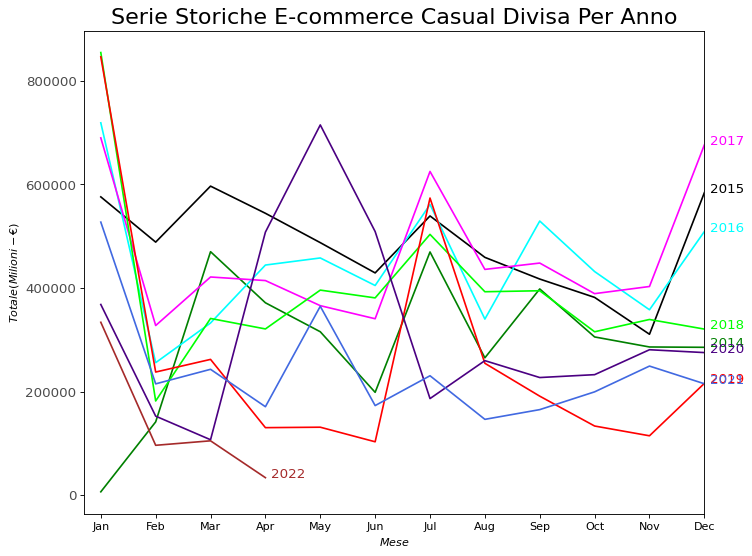

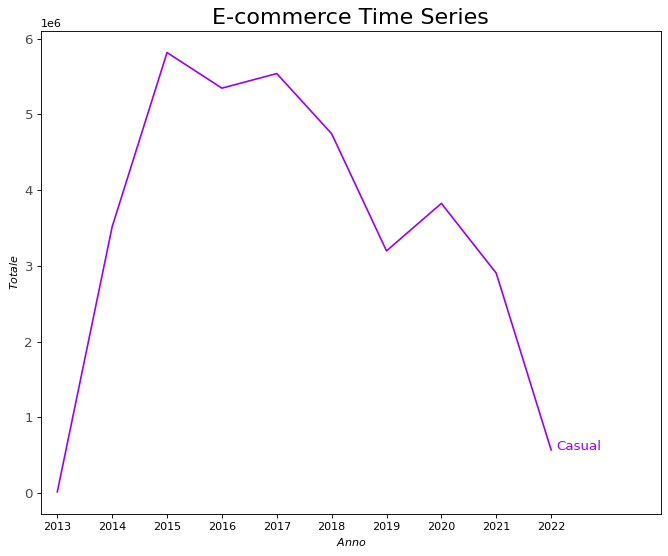

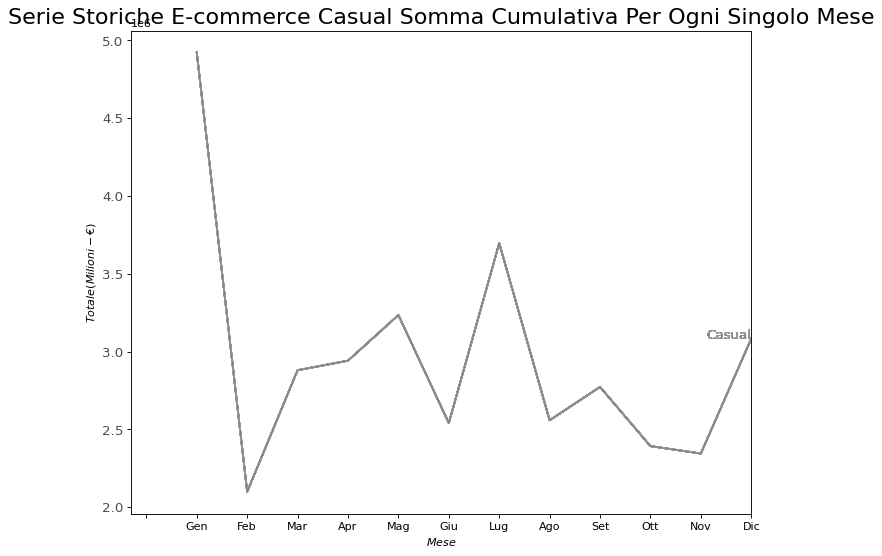

In [12]:
dataCasualAnnoMese = dataCasual
dataCasualTotalePerMese = dataCasual
dataCasualMese = dataCasual
dataCasualAnno = dataCasual
strCasual = "Casual"
(dataCasualAnnoMese, dataCasualTotalePerMese, dataCasualMese) = function(dataCasual, dataCasualAnnoMese, dataCasualTotalePerMese, dataCasualMese)
dataCasualAnno = totaleAnno(dataCasualAnno, dataCasual, strCasual)
dataCasualTotalePerMese = totaleMese(dataCasualTotalePerMese, dataCasual, strCasual)

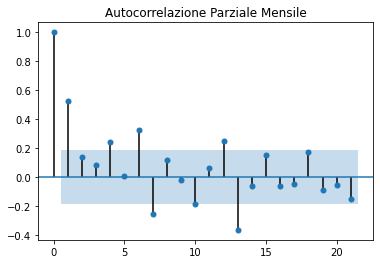

In [13]:
# print(dataCasualMese)
tempCasual =  dataCasualMese.drop(columns = ['year', 'month'])
# print(tempCasual)

plot_pacf(tempCasual, title = "Autocorrelazione Parziale Mensile");

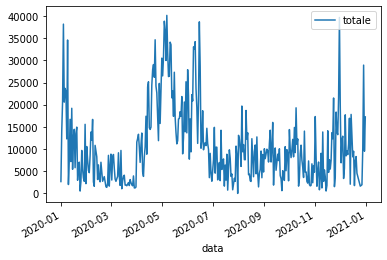

In [14]:
# print(dataCasual)
dataCasual = dataCasual.set_index('data')
dataCasual.index = pd.to_datetime(dataCasual.index)
dataCasual2020 = dataCasual[dataCasual.index.year == 2020]
dataCasual2020.plot()

In [15]:
dataRt1 = pd.read_csv('iss_rt_italia.csv', sep = ",")
#dataRt1 = dataRt1.iloc[268:350]
dataRt1 = dataRt1.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici', 'rt_sintomatici_err68perc'])
dataRt1 = dataRt1.set_index('data')
dataRt1.index = pd.to_datetime(dataRt1.index)
dataRt1

dataRt1Week = dataRt1
dataRt1Week = dataRt1Week.groupby(pd.Grouper(freq='W-MON')).last()
# print(dataRt1Week)

In [16]:
merge0=pd.merge(dataCasual2020, dataRt1, how='inner', right_index=True, left_index = True)
#print(merge0)
merge0 = merge0.drop(columns=['settore'])
merge0.corr()

,totale,rt_positivi
totale,1.000000,-0.482078
rt_positivi,-0.482078,1.000000


In [17]:
dataCasualLockdown = dataCasual[dataCasual.index >= '2020-03-09']
dataCasualLockdown = dataCasualLockdown[dataCasualLockdown.index <= '2020-03-31']
#dataCasualLockdown
merge1=pd.merge(dataCasualLockdown, dataRt1, how='inner', right_index=True, left_index = True)
#print(merge1)
merge1 = merge1.drop(columns=['settore'])
merge1.corr()

,totale,rt_positivi
totale,1.00000,0.51494
rt_positivi,0.51494,1.00000


In [18]:
# merge0 = merge0.drop(columns=['rt_positivi'])
# merge0.plot()

In [19]:
# dataRt = pd.read_csv('iss_rt_italia.csv', sep = ";")
# dataRt['rt_positivi'] = dataRt['rt_positivi']/10**16

# for index, row in dataRt.iterrows():
#   if (row['rt_positivi'] < 0.001):
#     dataRt.rt_positivi = row['rt_positivi'] * 1000
#     print(index)
#   elif (row['rt_positivi'] < 0.01):
#     row['rt_positivi'] = row['rt_positivi'] * 100
#   elif (row['rt_positivi'] < 0.1):
#     row['rt_positivi'] = row['rt_positivi'] * 10

# for i in range(len(dataRt)):
#   if(dataRt.rt_positivi[i] <0.1):


In [20]:
#display(dataRt)

Creazione array per covid

lockdown - 1

aperti - 0

In [21]:
# lockdown 9/3/2020 - 18/05/2020
# zona rossa: nov 2020 + dic 2020 + fino al 10/01 2021
            # da 10/03/21 a fine aprile 21

listLock1 = ['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
              '2020-03-16', '2020-03-17','2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
              '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
              '2020-03-30', '2020-03-31',
              '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
              '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
              '2020-04-13', '2020-04-14','2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
              '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
              '2020-04-27', '2020-04-28','2020-04-29', '2020-04-30',
              '2020-05-01', '2020-05-02','2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
              '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
             '2020-05-15','2020-05-16','2020-05-17','2020-05-18',

             #zona rossa
             '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07', 
             '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15',
             '2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21', '2020-11-22', '2020-11-23',
             '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',   

             '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08', 
             '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15','2020-12-16', 
             '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24', 
             '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-30', '2020-12-31',

             '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', 
             '2021-01-09', '2021-01-10',
             '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17',
             '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
             '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', 
             '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', 
             '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
             '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
             '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'
             ]

def strtodate (stringa):
  today = datetime.strptime(stringa, "%Y-%m-%d")
  return today

listLock = set([])
for i in listLock1:
  data = strtodate(i)
  listLock.add(data)

# listLock

In [22]:
# import numpy as np
# import datetime as dt
# import pandas as pd
# listOfDates = pd.date_range(start="2021-03-10",end="2021-04-30")
# print(listOfDates)

In [23]:
# for index, row in dataRt1.iterrows():
#   print(index)
#   if (row['rt_positivi'] > 1.25 & index in listLock1):
#     dataRt1.at[index,'liberi'] = 0 
#   else:
#     dataRt1.at[index,'liberi'] = 1
    
# dataRt1
inizioLock = datetime.strptime('2020-03-09', "%Y-%m-%d")
fineLock = datetime.strptime('2020-05-18', "%Y-%m-%d")
dataRt1['lockdown'] = 0
s = list(listLock)
for i in range (len(s)):
  timestamp = datetime.timestamp(s[i])
  s[i] = timestamp


for index, row in dataRt1.iterrows():
  timestamp = datetime.timestamp(index)
  if (timestamp in s):
    dataRt1.at[index,'lockdown'] = 1 
  # elif (row['rt_positivi'] > 1.25):  #((timestamp < datetime.timestamp(inizioLock)) or (timestamp > datetime.timestamp(fineLock))) and 
  #   dataRt1.at[index,'liberi'] = 1
  else:
    dataRt1.at[index,'lockdown'] = 0

# dataRt1

# listRossa = []

In [24]:
mergeCasualCovid=pd.merge(dataCasual, dataRt1, how='inner', right_index=True, left_index = True)
mergeCasualCovid = mergeCasualCovid.drop(columns=['lockdown']) # droppare ???
# dataCasual

# print(mergeCasualCovid)

In [25]:
mergeCasualCovid.corr()

,totale,rt_positivi
totale,1.000000,-0.237527
rt_positivi,-0.237527,1.000000


Text(0.5, 0, 'Data')

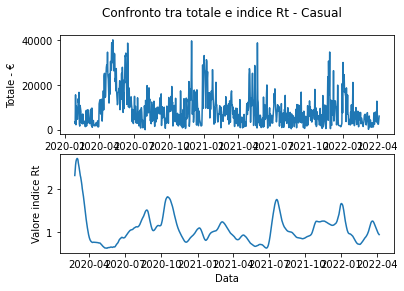

In [26]:
x = mergeCasualCovid.index
y = mergeCasualCovid.totale
z = mergeCasualCovid.rt_positivi

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Confronto tra totale e indice Rt - Casual')
ax1.plot(x, y)
ax1.set_ylabel("Totale - €")
ax2.plot(x, z)
ax2.set_ylabel("Valore indice Rt")
ax2.set_xlabel("Data") 

##Trend + stazionarietà (da sistemare)

In [27]:
#raggruppo i dati settimanalmente
dataCasualWeek = dataCasual.groupby(pd.Grouper(freq='W-MON')).sum()
print(dataCasualWeek)

               totale
data                 
2013-04-08    1962.15
2013-04-15       0.00
2013-04-22       0.00
2013-04-29       0.00
2013-05-06       0.00
2013-05-13       0.00
2013-05-20       0.00
2013-05-27       0.00
2013-06-03       0.00
2013-06-10       0.00
2013-06-17       0.00
2013-06-24       0.00
2013-07-01       0.00
2013-07-08       0.00
2013-07-15       0.00
2013-07-22    3336.20
2013-07-29    3086.09
2013-08-05     429.82
2013-08-12    3121.43
2013-08-19       0.00
2013-08-26       0.00
2013-09-02       0.00
2013-09-09       0.00
2013-09-16       0.00
2013-09-23     552.62
2013-09-30       0.00
2013-10-07    1716.81
2013-10-14       0.00
2013-10-21       0.00
2013-10-28       0.00
2013-11-04       0.00
2013-11-11       0.00
2013-11-18    1842.08
2013-11-25       0.00
2013-12-02       0.00
2013-12-09      54.58
2013-12-16       0.00
2013-12-23       0.00
2013-12-30       0.00
2014-01-06       0.00
2014-01-13       0.00
2014-01-20    4762.11
2014-01-27       0.00
2014-02-03

In [28]:
#Statsmodels -- TREND
from statsmodels.tsa.filters.hp_filter import hpfilter
gdp_cycle, gdp_trend = hpfilter(dataCasualWeek['totale'], lamb=270400) #lambda = 1600 *13^2

In [29]:
dataCasualWeek['trend'] = gdp_trend

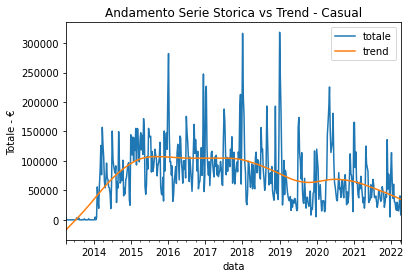

In [30]:
dataCasualWeek[['totale','trend']].plot(ylabel = "Totale - €", title = "Andamento Serie Storica vs Trend - Casual").autoscale(axis='x',tight=True);

In [31]:
#Error/Trend/Seasonality Models
N = 44
dataCasual2 = dataCasualWeek.iloc[N:]

dataCasualWeek = dataCasual2

In [32]:
#Moving Averages
#Simple Moving Average - SMA

dataCasualWeek['6-month-SMA'] = dataCasualWeek['totale'].rolling(window=24).mean()
dataCasualWeek['12-month-SMA'] = dataCasualWeek['totale'].rolling(window=12*4).mean()
dataCasualWeek['12-month-Std'] = dataCasualWeek['totale'].rolling(window=12*4).std()
dataCasualWeek.head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,totale,trend,6-month-SMA,12-month-SMA,12-month-Std
data,,,,,
2014-02-10,55915.84,41688.177851,NaN,NaN,NaN
2014-02-17,31897.64,43152.414086,NaN,NaN,NaN
2014-02-24,19541.82,44612.718859,NaN,NaN,NaN
2014-03-03,59256.69,46067.468329,NaN,NaN,NaN
2014-03-10,84110.24,47514.945941,NaN,NaN,NaN
2014-03-17,126103.26,48953.483913,NaN,NaN,NaN
2014-03-24,76565.37,50381.549805,NaN,NaN,NaN
2014-03-31,157164.21,51797.896490,NaN,NaN,NaN
2014-04-07,126968.63,53201.373678,NaN,NaN,NaN


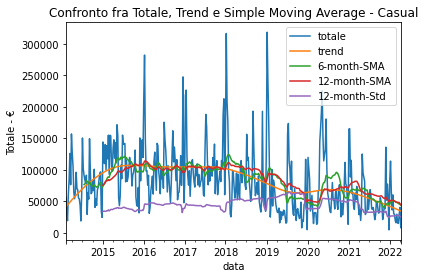

In [33]:
c = dataCasualWeek.plot(ylabel = "Totale - €", title="Confronto fra Totale, Trend e Simple Moving Average - Casual");
c.legend(loc=1, prop={'size': 10})

In [34]:
#EWMA
dataCasualWeek['EWMA12'] = dataCasualWeek['totale'].ewm(span=12,adjust=False).mean()

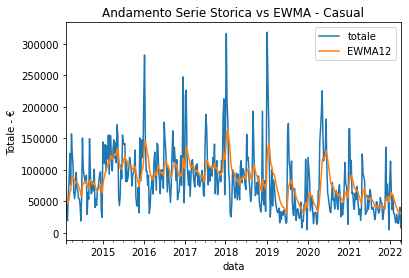

In [35]:
dataCasualWeek[['totale','EWMA12']].plot(ylabel = "Totale - €", title = "Andamento Serie Storica vs EWMA - Casual");

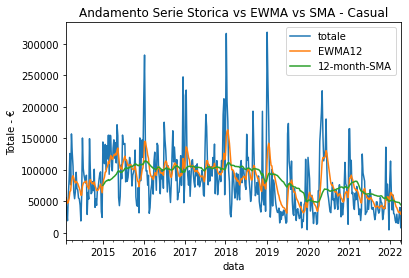

In [36]:
#Comparing SMA con EWMA
dataCasualWeek[['totale','EWMA12','12-month-SMA']].plot(ylabel = "Totale - €",
                                                       title = "Andamento Serie Storica vs EWMA vs SMA - Casual").autoscale(axis='x',tight=True);



In [37]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12*4
alpha = 2/(span+1)

dataCasual2['EWMA12'] = dataCasual2['totale'].ewm(alpha=alpha,adjust=False).mean()
dataCasual2['SES12']=SimpleExpSmoothing(dataCasual2['totale']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
dataCasual2.head()

,totale,trend,6-month-SMA,12-month-SMA,12-month-Std,EWMA12,SES12
data,,,,,,,
2014-02-10,55915.84,41688.177851,NaN,NaN,NaN,55915.840000,55915.840000
2014-02-17,31897.64,43152.414086,NaN,NaN,NaN,54935.505306,54935.505306
2014-02-24,19541.82,44612.718859,NaN,NaN,NaN,53490.865090,53490.865090
2014-03-03,59256.69,46067.468329,NaN,NaN,NaN,53726.204882,53726.204882
2014-03-10,84110.24,47514.945941,NaN,NaN,NaN,54966.369581,54966.369581


In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

dataCasual2['DESadd12'] = ExponentialSmoothing(dataCasual2['totale'], trend='add').fit().fittedvalues.shift(-1)
dataCasual2.head()

,totale,trend,6-month-SMA,12-month-SMA,12-month-Std,EWMA12,SES12,DESadd12
data,,,,,,,,
2014-02-10,55915.84,41688.177851,NaN,NaN,NaN,55915.840000,55915.840000,55915.839999
2014-02-17,31897.64,43152.414086,NaN,NaN,NaN,54935.505306,54935.505306,42678.719762
2014-02-24,19541.82,44612.718859,NaN,NaN,NaN,53490.865090,53490.865090,29927.309411
2014-03-03,59256.69,46067.468329,NaN,NaN,NaN,53726.204882,53726.204882,46091.573901
2014-03-10,84110.24,47514.945941,NaN,NaN,NaN,54966.369581,54966.369581,67044.753341


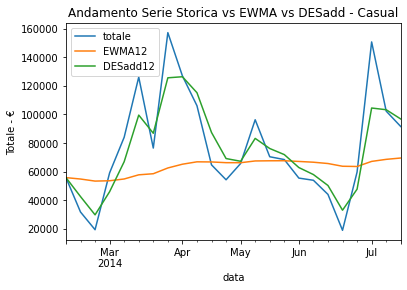

In [39]:
dataCasual2[['totale','EWMA12','DESadd12']].iloc[:24].plot(ylabel = "Totale - €",
                                                       title = "Andamento Serie Storica vs EWMA vs DESadd - Casual"
                                                       ).autoscale(axis='x',tight=True);
# print(dataCasual2.totale)
# print(dataCasual2.DESadd12)

In [40]:
dataCasual2['DESmul12'] = ExponentialSmoothing(dataCasual2['totale'], trend='mul').fit().fittedvalues.shift(-1)
dataCasual2.head()

,totale,trend,6-month-SMA,12-month-SMA,12-month-Std,EWMA12,SES12,DESadd12,DESmul12
data,,,,,,,,,
2014-02-10,55915.84,41688.177851,NaN,NaN,NaN,55915.840000,55915.840000,55915.839999,52837.096956
2014-02-17,31897.64,43152.414086,NaN,NaN,NaN,54935.505306,54935.505306,42678.719762,38593.253588
2014-02-24,19541.82,44612.718859,NaN,NaN,NaN,53490.865090,53490.865090,29927.309411,26011.806590
2014-03-03,59256.69,46067.468329,NaN,NaN,NaN,53726.204882,53726.204882,46091.573901,44243.071420
2014-03-10,84110.24,47514.945941,NaN,NaN,NaN,54966.369581,54966.369581,67044.753341,65585.476189


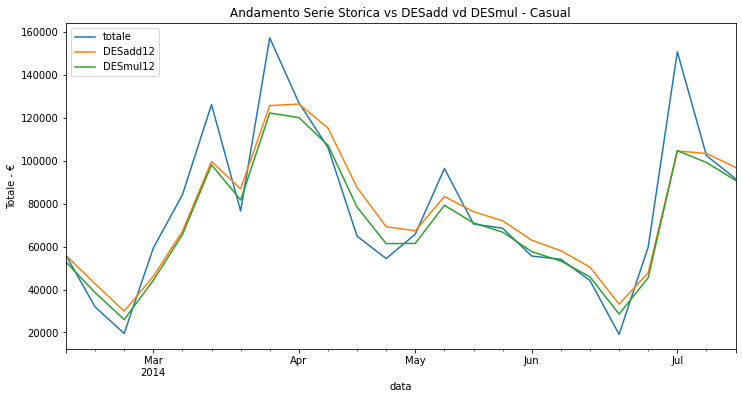

In [41]:
dataCasual2[['totale','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6), 
                                                             ylabel = "Totale - €",
                                                       title = "Andamento Serie Storica vs DESadd vd DESmul - Casual"
                                                       ).autoscale(axis='x',tight=True);

In [42]:
#triple exponential smoothing
dataCasual2['TESadd12'] = ExponentialSmoothing(dataCasual2['totale'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
dataCasual2.head()

,totale,trend,6-month-SMA,12-month-SMA,12-month-Std,EWMA12,SES12,DESadd12,DESmul12,TESadd12
data,,,,,,,,,,
2014-02-10,55915.84,41688.177851,NaN,NaN,NaN,55915.840000,55915.840000,55915.839999,52837.096956,77560.452222
2014-02-17,31897.64,43152.414086,NaN,NaN,NaN,54935.505306,54935.505306,42678.719762,38593.253588,62220.425564
2014-02-24,19541.82,44612.718859,NaN,NaN,NaN,53490.865090,53490.865090,29927.309411,26011.806590,47657.445351
2014-03-03,59256.69,46067.468329,NaN,NaN,NaN,53726.204882,53726.204882,46091.573901,44243.071420,34544.760055
2014-03-10,84110.24,47514.945941,NaN,NaN,NaN,54966.369581,54966.369581,67044.753341,65585.476189,56750.339116


In [43]:
dataCasual2['TESmul12'] = ExponentialSmoothing(dataCasual2['totale'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
dataCasual2.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,totale,trend,6-month-SMA,12-month-SMA,12-month-Std,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
data,,,,,,,,,,,
2014-02-10,55915.84,41688.177851,NaN,NaN,NaN,55915.840000,55915.840000,55915.839999,52837.096956,77560.452222,55490.160280
2014-02-17,31897.64,43152.414086,NaN,NaN,NaN,54935.505306,54935.505306,42678.719762,38593.253588,62220.425564,31427.174991
2014-02-24,19541.82,44612.718859,NaN,NaN,NaN,53490.865090,53490.865090,29927.309411,26011.806590,47657.445351,19123.272225
2014-03-03,59256.69,46067.468329,NaN,NaN,NaN,53726.204882,53726.204882,46091.573901,44243.071420,34544.760055,57619.471849
2014-03-10,84110.24,47514.945941,NaN,NaN,NaN,54966.369581,54966.369581,67044.753341,65585.476189,56750.339116,81301.513404


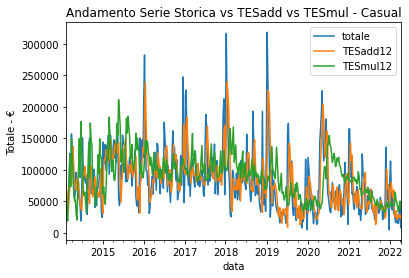

In [44]:
dataCasual2[['totale','TESadd12','TESmul12']].plot(ylabel = "Totale - €",
                                                       title = "Andamento Serie Storica vs TESadd vs TESmul - Casual"
                                                       ).autoscale(axis='x',tight=True);

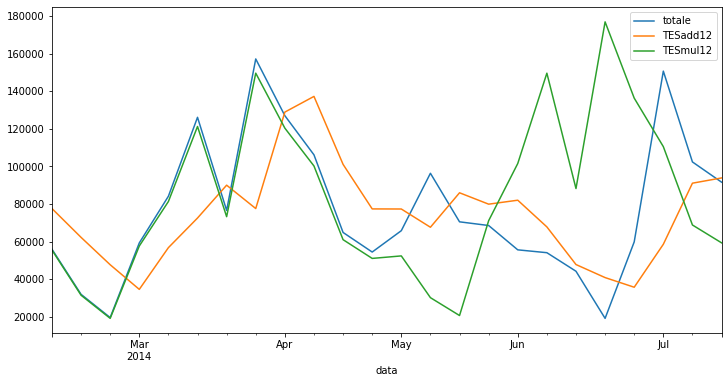

In [45]:
dataCasual2[['totale','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

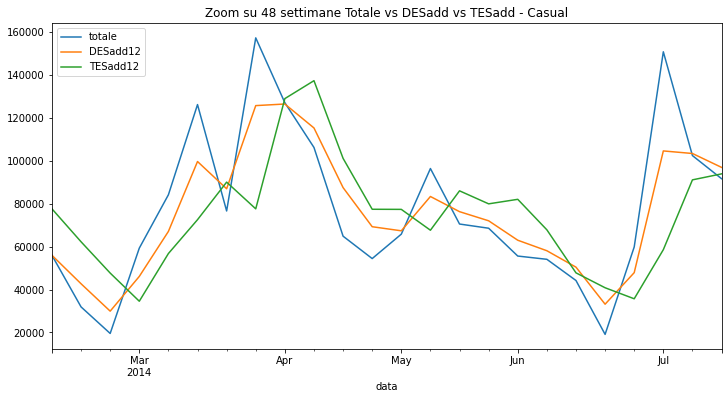

In [47]:
dataCasual2[['totale','DESadd12','TESadd12']].iloc[:24].plot(title = "Zoom su 48 settimane Totale vs DESadd vs TESadd - Casual", 
                                                             figsize=(12,6)).autoscale(axis='x',tight=True);